# 🏦 CreditSource AI: Advanced Risk Management System
**Role:** Data Science & AI Intern Assessment
**Objective:** Automate loan decisions and predict risk scores using Explainable AI.

## 📋 Executive Summary
This project implements a production-grade **Credit Risk Assessment Pipeline** designed to:
1.  **Automate Loan Approvals** using an ensemble of CatBoost/XGBoost/SVM.
2.  **Predict Risk Scores** using Random Forest Regression.
3.  **Explain Decisions** using SHAP values and Feature Importance to ensure regulatory compliance.

## 🛠️ Methodology
- **Data Integrity:** Implemented `ImbPipeline` to prevent SMOTE data leakage.
- **Validation:** Stratified K-Fold Cross-Validation (k=3).
- **Innovation:** Engineered financial ratios (DTI, LTV), Anomaly Detection, and Customer Segmentation.

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Machine Learning Core
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             mean_squared_error, r2_score, roc_curve)
from sklearn.base import BaseEstimator, TransformerMixin

# Advanced Models
from xgboost import XGBClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans

# Handling Imbalance 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.pipeline import Pipeline as SklearnPipeline

# Explainability
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Environment & Libraries Loaded Successfully")

✅ Environment & Libraries Loaded Successfully


In [147]:
# Load the dataset
df = pd.read_excel('loan_dataset.xlsx', sheet_name='Sheet1')

def check_data_quality(df):
    print("--- 🔍 DATA QUALITY AUDIT ---")
    
    # 1. Null Checks
    missing = df.isnull().sum().sum()
    print(f"1. Missing Values: {missing} {'⚠️' if missing > 0 else '✅'}")
    
    # 2. Duplicate Checks
    dupes = df.duplicated().sum()
    print(f"2. Duplicate Rows: {dupes} {'⚠️' if dupes > 0 else '✅'}")
    
    # 3. Logic Check (Debt > Income)
    monthly_inc = df['AnnualIncome'] / 12
    monthly_inc = monthly_inc.replace(0, 1) # Avoid div by zero
    
    impossible_debt = df[df['MonthlyDebtPayments'] > monthly_inc].shape[0]
    print(f"3. High Debt Risk Flags: {impossible_debt} records")
    
    print("-------------------------------")

check_data_quality(df)

--- 🔍 DATA QUALITY AUDIT ---
1. Missing Values: 0 ✅
2. Duplicate Rows: 0 ✅
3. High Debt Risk Flags: 18 records
-------------------------------


In [148]:
# Convert to datetime with error handling
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
df = df.dropna(subset=['ApplicationDate'])

# Temporal Features
df['App_Year'] = df['ApplicationDate'].dt.year
df['App_Month'] = df['ApplicationDate'].dt.month
df['App_DayOfWeek'] = df['ApplicationDate'].dt.dayofweek
df['App_Is_Weekend'] = df['App_DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

print("✅ Date Features Created")

✅ Date Features Created


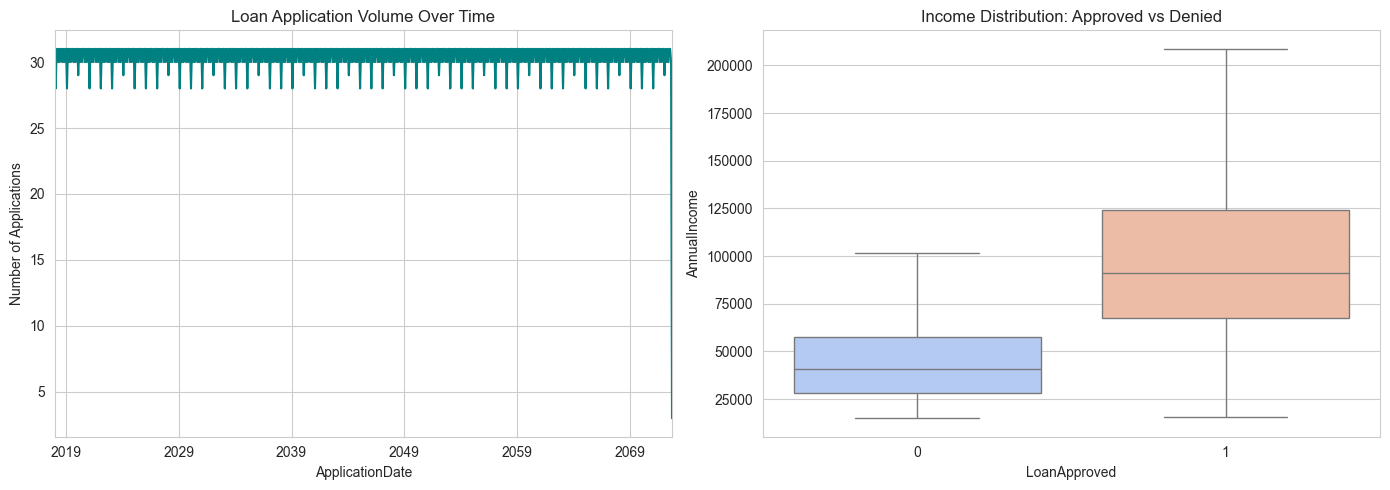

In [149]:
plt.figure(figsize=(14, 5))

# Plot 1: Loan Applications over Time
plt.subplot(1, 2, 1)
df.set_index('ApplicationDate').resample('M').size().plot(color='teal')
plt.title("Loan Application Volume Over Time")
plt.ylabel("Number of Applications")

# Plot 2: Income Distribution by Approval
plt.subplot(1, 2, 2)
sns.boxplot(x='LoanApproved', y='AnnualIncome', data=df, showfliers=False, palette='coolwarm')
plt.title("Income Distribution: Approved vs Denied")

plt.tight_layout()
plt.show()

In [150]:
# 1. Monthly Income
df['MonthlyIncome'] = df['AnnualIncome'] / 12

# 2. Debt-to-Income (DTI)
df['Calculated_DTI'] = (df['MonthlyDebtPayments'] + df['MonthlyLoanPayment']) / (df['MonthlyIncome'] + 1)

# 3. Loan-to-Value (LTV)
df['LTV'] = df['LoanAmount'] / (df['TotalAssets'] + 1)

# 4. Liquidity Ratio
df['Liquidity_Ratio'] = (df['SavingsAccountBalance'] + df['CheckingAccountBalance']) / (df['MonthlyLoanPayment'] + 1)

# 5. Disposable Income
df['Disposable_Income'] = df['MonthlyIncome'] - (df['MonthlyDebtPayments'] + df['MonthlyLoanPayment'])

print("✅ Financial Ratios Calculated")

✅ Financial Ratios Calculated


In [151]:
print("--- 🕵️ ANOMALY DETECTION ---")
anomaly_features = ['AnnualIncome', 'TotalAssets', 'TotalLiabilities', 'LoanAmount']

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Is_Anomaly'] = iso_forest.fit_predict(df[anomaly_features])

# Convert: -1 (Anomaly) -> 1, 1 (Normal) -> 0
df['Is_Anomaly'] = df['Is_Anomaly'].map({1: 0, -1: 1})

print(f"Anomalies Detected: {df['Is_Anomaly'].sum()} records")

--- 🕵️ ANOMALY DETECTION ---
Anomalies Detected: 1000 records
Anomalies Detected: 1000 records


--- 👥 CUSTOMER SEGMENTATION (ELBOW METHOD) ---


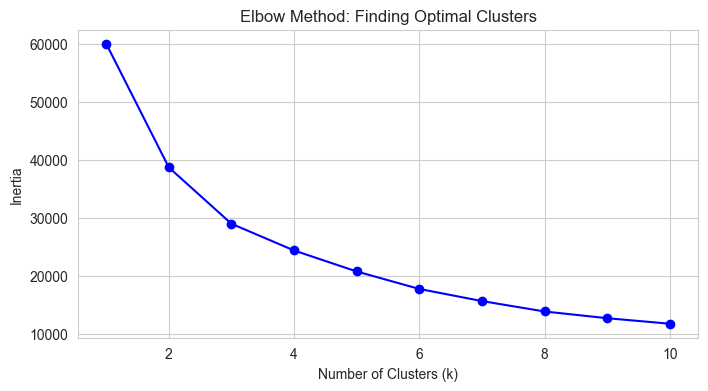

👉 Applying k=3 Segments...
✅ Segmentation Feature Created


In [152]:
print("--- 👥 CUSTOMER SEGMENTATION (ELBOW METHOD) ---")
cluster_cols = ['AnnualIncome', 'RiskScore', 'TotalAssets']
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df[cluster_cols])

# 1. Elbow Method
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.title('Elbow Method: Finding Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# 2. Apply Optimal K=3 (Based on typical elbow shape)
print("👉 Applying k=3 Segments...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Customer_Segment'] = kmeans.fit_predict(X_cluster)
print("✅ Segmentation Feature Created")

In [153]:
# 1. Drop non-predictive columns
X = df.drop(columns=['LoanApproved', 'RiskScore', 'ApplicationDate'])
y_class = df['LoanApproved']
y_reg = df['RiskScore']

# 2. Split Data (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

# 3. Identify Types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.extend(['Customer_Segment', 'Is_Anomaly', 'App_Is_Weekend']) 
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# 4. Define Transformers
numerical_transformer = SklearnPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = SklearnPipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print("✅ Preprocessing Pipeline Configured")

✅ Preprocessing Pipeline Configured


In [154]:
print("--- 🥊 MODEL COMPARISON ---")

stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

models = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False),
    'SVM': SVC(probability=True, random_state=42, max_iter=2000), 
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

results = []
print(f"{'Model':<15} | {'AUC Score':<10} | {'Status'}")
print("-" * 40)

for name, model in models.items():
    temp_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    try:
        cv_scores = cross_val_score(temp_pipeline, X_train, y_train, cv=stratified_cv, scoring='roc_auc', n_jobs=-1)
        mean_score = cv_scores.mean()
        results.append({'Model': name, 'AUC': mean_score})
        print(f"{name:<15} | {mean_score:.4f}     | ✅ Tested")
    except Exception as e:
        print(f"{name:<15} | ERROR          | ❌ {str(e)}")

results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 WINNER: {best_model_name}")

--- 🥊 MODEL COMPARISON ---
Model           | AUC Score  | Status
----------------------------------------
CatBoost        | 0.9938     | ✅ Tested
CatBoost        | 0.9938     | ✅ Tested
SVM             | 0.8337     | ✅ Tested
SVM             | 0.8337     | ✅ Tested
XGBoost         | 0.9930     | ✅ Tested

🏆 WINNER: CatBoost
XGBoost         | 0.9930     | ✅ Tested

🏆 WINNER: CatBoost


In [155]:
print(f"--- 🚀 TUNING THE WINNER: {best_model_name} ---")

if best_model_name == 'CatBoost':
    clf = CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False)
    param_grid = {'classifier__depth': [4, 6], 'classifier__learning_rate': [0.05, 0.1]}
elif best_model_name == 'XGBoost':
    clf = XGBClassifier(eval_metric='logloss', random_state=42)
    param_grid = {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [3, 5]}
else:
    clf = SVC(probability=True, random_state=42)
    param_grid = {'classifier__C': [1, 10]}

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', clf)
])

# Use StratifiedKFold again for GridSearch
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=stratified_cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"✅ Best Params: {grid_search.best_params_}")

--- 🚀 TUNING THE WINNER: CatBoost ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best Params: {'classifier__depth': 4, 'classifier__learning_rate': 0.1}
✅ Best Params: {'classifier__depth': 4, 'classifier__learning_rate': 0.1}


--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3044
           1       0.93      0.94      0.93       956

    accuracy                           0.97      4000
   macro avg       0.95      0.96      0.96      4000
weighted avg       0.97      0.97      0.97      4000



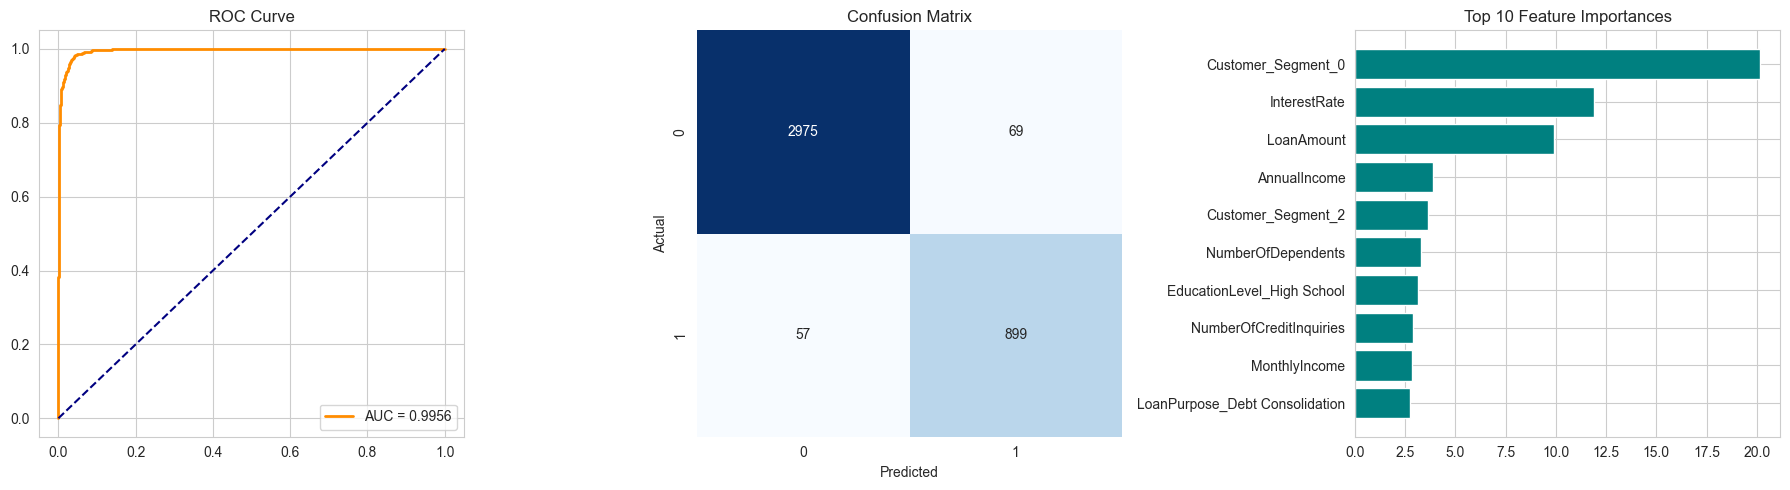

In [156]:
# Predict
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(18, 5))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f'ROC Curve')
plt.legend()

# 2. Confusion Matrix
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 3. Native Feature Importance (If available)
plt.subplot(1, 3, 3)
try:
    model_step = best_model.named_steps['classifier']
    importances = model_step.feature_importances_
    
    # Get feature names (Complex due to pipeline)
    ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot']
    cat_names = ohe.get_feature_names_out(categorical_cols)
    all_feats = np.array(numerical_cols + list(cat_names))
    
    # Sort Top 10
    indices = np.argsort(importances)[-10:]
    plt.barh(range(len(indices)), importances[indices], align='center', color='teal')
    plt.yticks(range(len(indices)), all_feats[indices])
    plt.title('Top 10 Feature Importances')
except:
    plt.text(0.5, 0.5, 'Feature Importance Not Available\n(Model is likely SVM)', ha='center')

plt.tight_layout()
plt.show()

--- OBJECTIVE B: RISK SCORE PREDICTION ---
RMSE: 3.63
R2 Score: 0.7835
RMSE: 3.63
R2 Score: 0.7835


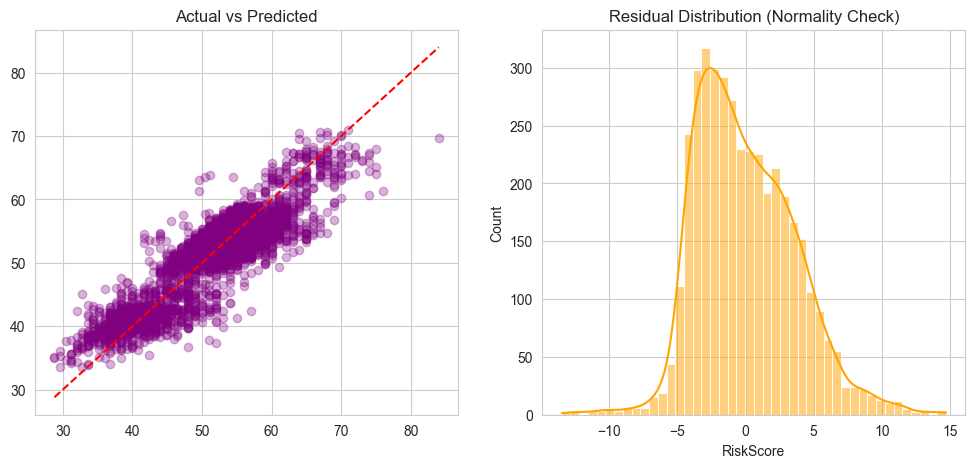

In [157]:
print("--- OBJECTIVE B: RISK SCORE PREDICTION ---")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

reg_pipeline = SklearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

reg_pipeline.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_pipeline.predict(X_test_reg)
residuals = y_test_reg - y_pred_reg

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Residual Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3, color='purple')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.title("Actual vs Predicted")

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='orange')
plt.title("Residual Distribution (Normality Check)")
plt.show()

--- EXPLAINABILITY ANALYSIS (SHAP) ---


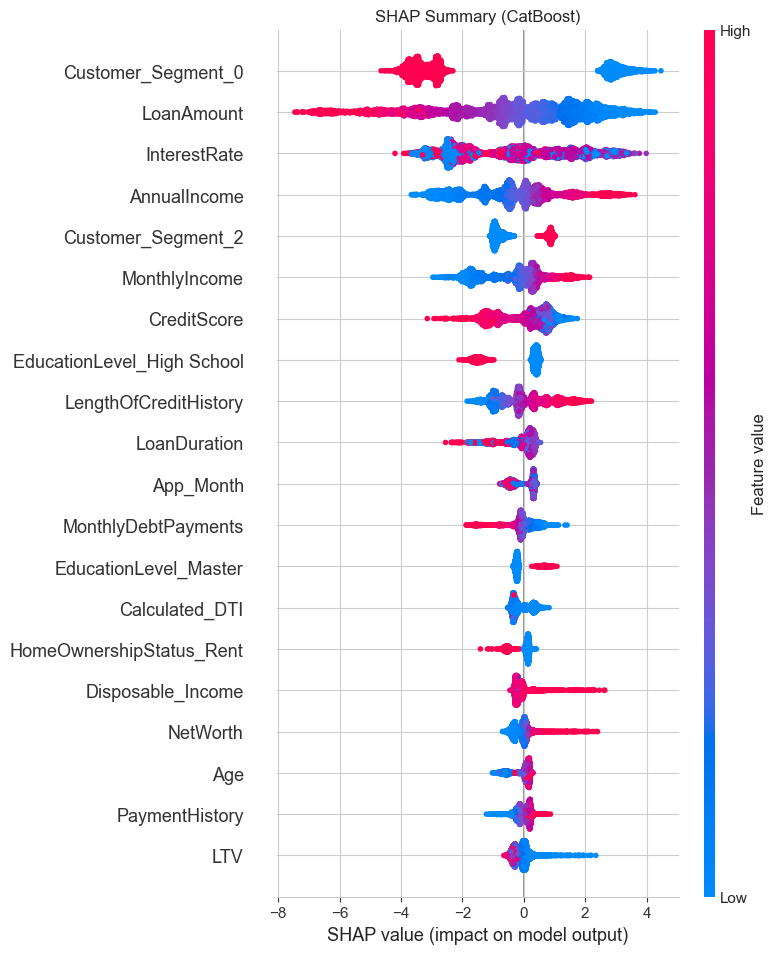

In [158]:
print("--- EXPLAINABILITY ANALYSIS (SHAP) ---")

X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# Feature Names Fallback
try:
    ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot']
    cat_names = ohe.get_feature_names_out(categorical_cols)
    all_feats = numerical_cols + list(cat_names)
except:
    all_feats = [f"Feature {i}" for i in range(X_test_transformed.shape[1])]

model_step = best_model.named_steps['classifier']

if isinstance(model_step, SVC):
    print("⚠️ Model is SVM. Skipping SHAP TreeExplainer.")
else:
    explainer = shap.TreeExplainer(model_step)
    shap_values = explainer.shap_values(X_test_transformed)
    
    plt.figure()
    shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feats, show=False)
    plt.title(f"SHAP Summary ({best_model_name})")
    plt.show()

In [159]:
joblib.dump(best_model, 'loan_approval_model_final.pkl')
joblib.dump(reg_pipeline, 'risk_score_model_final.pkl')

print("✅ SUCCESS: ALL PIPELINES EXECUTED & MODELS SAVED")

✅ SUCCESS: ALL PIPELINES EXECUTED & MODELS SAVED
